---
---
# NEURAL NETWORKS AND DEEP LEARNING

### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli

### Saverio Monaco
##### MAT: 2012264

# Homework 1 - Supervised Deep Learning
---
---

## Classification task

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

In [1]:
# if True all the models will be loaded from ./models folder
# if False all the models will be trained
load = False

### Dataset

In [2]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np

# Deep Learning stuff
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Images display and plots
import matplotlib.pyplot as plt

# Other
import os
import time
from tqdm.notebook import tqdm # Pretty progress bars


In [3]:
# Setting the values of the seeds for reproducibility
torch.manual_seed(2012264)    
np.random.seed(2012264)


In [4]:
# If we have already the datafolder, do not download.
if(os.path.isdir('./classifier_data/FashionMNIST')):
    download_data = False
else:
    download_data = True
    
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=download_data,
                                                     transform = transforms.Compose([transforms.ToTensor()]) )
                                                      
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=download_data,
                                                     transform = transforms.Compose([transforms.ToTensor()]) )


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size = 100, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size = 10000, shuffle=True, num_workers=0)


In [6]:
print('Number of instances in training dataset:', np.shape(train_dataset.data)[0])
print('Number of instances in testing dataset: ', np.shape(test_dataset.data)[0])

print('\nSize of the images:', np.shape(train_dataset.data[0].numpy()))


Number of instances in training dataset: 60000
Number of instances in testing dataset:  10000

Size of the images: (28, 28)


In [7]:
# Check for the ranges of value of the images
# There are two standards of representing grayscale images:
#  1. Each pixel ranges from 0 to 1
#  2. Each pixel ranges from 0 to 255

# The second one present more numerical instability

absmax = -1000
absmin = +1000

# Checking the whole dataset, just to be sure
for image_batch, _ in train_dataloader:
    batch_max = torch.max(image_batch)
    batch_min = torch.min(image_batch)
    
    if batch_max > absmax:
        absmax = batch_max
    if batch_min < absmin:
        absmin = batch_min
        
print('TRAINING DATASET')
print(' range:', absmin.item(), '-', absmax.item())

absmax = -1000
absmin = +1000

# Checking the whole dataset, just to be sure
for image_batch, _ in test_dataloader:
    batch_max = torch.max(image_batch)
    batch_min = torch.min(image_batch)
    
    if batch_max > absmax:
        absmax = batch_max
    if batch_min < absmin:
        absmin = batch_min

print('\nTEST DATASET')
print(' range:', absmin.item(), '-', absmax.item())


TRAINING DATASET
 range: 0.0 - 1.0

TEST DATASET
 range: 0.0 - 1.0


In [8]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")


Training device: cuda


In [9]:
def plot_mnistimg(dataset, sample, output = False, size = 3):
    '''
    Display the sample-th image from dataset (can be trainingset or testset) and its true
    label.
    Eventually display the predicted label in output.
    Size of the image can be changed changing size input parameter
    '''
    
    # Convert output (int) through the description of the images (str)
    description = ['T-shirt/top','Trouser','Pullover',
                   'Dress','Coat','Sandal','Shirt',
                   'Sneaker','Bag','Ankle boot']
    
    image = np.ones((28,28))-np.array(dataset[sample][0])[0] # Image to display
    label = dataset[sample][1]              # Relative label (int)

    fig = plt.figure(figsize=(size,size))
    plt.imshow(image, cmap='Greys')
    
    print(f"Sample: {sample}")
    print(f"True Label: {description[label]}")
    
    if output:
        print(f"Prediction: {description[output]}")
    
    plt.axis("off")
    plt.show()
    

Sample: 1
True Label: T-shirt/top


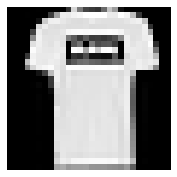

In [10]:
plot_mnistimg(train_dataset, 1)


### Building the Neural Network Structure

In [11]:
class CNNMnistNet(nn.Module):
    def __init__(self, Noutp, channels, activation = nn.ReLU(), dropout=0):
        """
        Ni - Input size  (INT)
        No - Output size (INT)
        Nhs - Hidden layers (LIST OF INTEGERS)
        """
        super(CNNMnistNet, self).__init__()
        
        self.activation = activation
        self.channels = channels
        
        if len(channels)!=2:
            print('Channels specified must be a list of two elements')
        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels  = 1, # Because image is grayscale              
                out_channels = channels[0],            
                kernel_size  = 5,              
                stride       = 1,                   
                padding      = 2,                  
            ),                              
            activation,                      
            nn.MaxPool2d(kernel_size=2),    
        )
        
        # Dropout between two convolutions
        self.dropout = nn.Dropout(dropout)
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels  = channels[0], 
                out_channels = channels[1], 
                kernel_size  = 5, 
                stride       = 1, 
                padding      =2
            ),     
            activation,                      
            nn.MaxPool2d(2),                
        )
        
        # Fully connected layer to output 10 classes
        self.out = nn.Linear(channels[1] * 7 * 7, Noutp)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output    # return x for visualization
    
    def compute_accuracy(self, heatmap = False, verbose = False, examples=False):
        '''
        Compute accuracy of the model (%) from the testset
        heatmap  = True shows heatmap
        verbose  = True prints accuracy
        examples = True display some examples
        '''
        self.to(device)
        self.eval()
        # Input and true label
        x_test,y_test = next(iter(test_dataloader))
        # Prediction
        y_pred = self(x_test.to(device)).argmax(dim=1)
        
        description = ['T-shirt/top','Trouser','Pullover',
                   'Dress','Coat','Sandal','Shirt',
                   'Sneaker','Bag','Ankle boot']
        
        misclas = 0
        for i in range(len(y_pred) ):
            if y_pred[i] != y_test[i]:
                misclas = misclas + 1
        
        accuracy = 100*(len(y_pred) - misclas)/len(y_pred)
        
        if verbose:
            print('Accuracy:', accuracy, '%' )
            
        if heatmap:
            conf_mat = confusion_matrix(y_test, y_pred.cpu())
            fig, ax = plt.subplots(figsize=(6,5))
            plt.title('Heatmap')
            sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=description, yticklabels=description)
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            
            if type(heatmap) is str:
                plt.savefig('./imgs/classification/'+heatmap+'.svg', format='svg')
            else:
                plt.show()
            
        if examples:
            indices = np.random.choice(np.arange(len(test_dataloader.dataset) ), size=5, replace=False)
            
            for index in indices:
                image = np.array(x_test[index][0])
                label = y_test[index]

                fig = plt.figure(figsize=(3,3))
                plt.imshow(image, cmap='Greys')
    
                print(f"\n\nTrue Label: {description[label]}")
                print(f"Prediction: {description[y_pred[index]]}")
    
                plt.axis("off")
                plt.show()
            
        return accuracy
    
    def fit(self, data, epochs, folds, torch_loss, printfreq, lr0, reg_term = 0, test=False, figname=False):
        '''
        Function for training the Network
        data:       Dataloader
        epochs:     Number of epochs for the model to learn
        folds:      Folds in the k-fold cross validation
        torch_loss: Torch funcion for the loss
        printfreq:  Frequency of printing train loss and validation loss
        lr0:        Initial Learning rate
        reg_term:   Regularization term L2 penalty
        test =True: Computes accuracy on testset at each epoch, and 
                    displays learning curves
        '''
        train_loss_log = [] 
        test_loss_log = []
        val_loss_log = []
        
        # Define the optimizer
        optimizer = optim.Adam(self.parameters(), lr=lr0, weight_decay= reg_term)
        self.to(device)
        for epoch in range(epochs):
            ### TRAIN
            train_loss = []
    
            self.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
            for sample_batched in data:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)
        
                kf = KFold(n_splits=folds)
                kf.get_n_splits(x_batch)
        
                loss = 0
                for train_index, val_index in kf.split(x_batch):
                    x_batch_train, x_batch_val = x_batch[train_index], x_batch[val_index]
                    y_batch_train, y_batch_val = label_batch[train_index], label_batch[val_index]

                    # Forward pass
                    out = self(x_batch_train)
        
                    # Compute loss
                    loss = loss + torch_loss(out, y_batch_train)/folds
                # Backpropagation
                self.zero_grad() # Clears gradient
                loss.backward()  # Computes the derivative of the loss

                # Update the weights
                optimizer.step() # Take a step based on the gradients

                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch)

            # Save average train loss
            train_loss = np.mean(train_loss)
    
            if printfreq!=0 and epoch%printfreq == 0:
                print('#################')
                print(f'# EPOCH {epoch}')
                print('#################')
                print(f"AVERAGE TRAIN LOSS: {train_loss}")
                
            train_loss_log.append(train_loss)
            
            ### VALIDATION
            val_loss= []
            self.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
            with torch.no_grad(): # Disable gradient tracking
                for sample_batched in data:
                    # Move data to device
                    x_batch = sample_batched[0].to(device)
                    label_batch = sample_batched[1].to(device)

                    kf = KFold(n_splits=folds)
                    kf.get_n_splits(x_batch)
        
                    loss = 0
                    for train_index, val_index in kf.split(x_batch):
                        x_batch_train, x_batch_val = x_batch[train_index], x_batch[val_index]
                        y_batch_train, y_batch_val = label_batch[train_index], label_batch[val_index]

                        # Forward pass
                        out = self(x_batch_val)

                        # Compute loss
                        loss = loss + torch_loss(out, y_batch_val)/folds
                
                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)
        
                # Save average validation loss
                val_loss = np.mean(val_loss)
                if printfreq!=0 and epoch%printfreq == 0:
                    print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
                    print('')
                val_loss_log.append(val_loss)
            
            if test:
                test_loss_log.append(self.compute_accuracy()) # Compute accuracy
                if printfreq!=0 and epoch%printfreq == 0:
                    print(f"TEST ACCURACY: {test_loss_log[-1]} %")
                    
        if test:
            fig=plt.figure(figsize = (4,6))
            ax1 = plt.subplot(211) # Loss on training
            ax2 = plt.subplot(212) # Accuracy on test
            
            xvalues = np.arange(0,epochs)
            
            ax1.set_title('Loss curves')
            
            ax1.plot(xvalues, val_loss_log  , label='Validation error', color='green')
            ax1.plot(xvalues, train_loss_log, label='Train error', color='blue')
            ax1.set_xlabel('epoch')
            ax1.legend()
            
            ax2.set_title('Accuracy on test set')
            ax2.set_ylabel('%')
            ax2.set_xlabel('epoch')
            ax2.set_ylim(-1,101)
            ax2.plot(xvalues, test_loss_log  , label='Test accuracy', color='gold')
            
            plt.tight_layout()
            
            if type(figname) is str:
                plt.savefig('./imgs/classification/'+figname+'.svg', format='svg')
            else:
                plt.show()
            
        return val_loss_log[-1]
    
    def plot_filters(self, figname=False):
        '''Functions for visualizing the filters'''
        filter1 = self.conv1[0].weight.data.cpu().numpy()
        filter2 = self.conv2[0].weight.data.cpu().numpy()
        
        # FIRST CHANNEL #
        fig, ax = plt.subplots(1,self.channels[0], figsize=(16, 3))

        for i in range(self.channels[0]):
            ax[i].imshow( filter1[i, 0, :, :], cmap='Greys')
            ax[i].axis('off')
    
        fig.suptitle('Filters of first convolutional layer')
        
        if figname:
            plt.savefig('./imgs/classification/'+figname+'layer1.svg', format='svg')
        else:
            plt.show()
        
        # SECOND CHANNEL #
        fig, ax = plt.subplots(self.channels[0], self.channels[1], figsize=(16, 7))

        for i in range(self.channels[0]):
            for j in range(self.channels[1]):
                ax[i,j].imshow( filter2[j, i, :,:], cmap='Greys')
                ax[i,j].axis('off')
        
        fig.suptitle('Filters of second convolutional layer')
        if figname:
            plt.savefig('./imgs/classification/'+figname+'layer2.svg', format='svg')
        else:
            plt.show()
        
    def plot_activations(self, figname=False):
        def get_activation(layer, input, output):
            global activation
            activation = self.activation(output)

        ex_dataloader =  DataLoader(test_dataset, batch_size = 1, shuffle=True, num_workers=0)
        
        ### Register hook  
        hook_handle = self.conv1.register_forward_hook(get_activation)

        ### Analyze activations
        self.eval()

        with torch.no_grad():
            for s_batch in ex_dataloader:
                # Move data to device
                x1 = s_batch[0].to(device)
                # Forward pass
                y1 = self(x1)
                z1 = activation

        ### Remove hook
        hook_handle.remove()

        act1 = z1.cpu().numpy()

        ## Plot activations
        fig, ax = plt.subplots(1, self.channels[0], figsize=(16,3))
        for i in range(self.channels[0]):
            ax[i].imshow( act1[0, i, :, :], cmap='Greys')
            ax[i].axis('off')

        fig.suptitle('Activation profile - first convolutional layer', fontsize=16)    
        plt.tight_layout()

        if figname:
            plt.savefig('./imgs/classification/'+figname+'activation1.svg', format='svg')
        else:
            plt.show()   
        
        ### Register hook  
        hook_handle = self.conv2.register_forward_hook(get_activation)

        with torch.no_grad():
            for s_batch in ex_dataloader:
                # Move data to device
                x2 = s_batch[0].to(device)
                # Forward pass
                y2 = self(x2)
                z2 = activation

        ### Remove hook
        hook_handle.remove()

        act2 = z2.cpu().numpy()

        ## Plot activations
        fig, ax = plt.subplots(2, self.channels[0], figsize=(16,6))

        for i in range(self.channels[0]):
            ax[0, i].imshow( act2[0, i, :, :], cmap='Greys')
            ax[0, i].axis('off')
            ax[1, i].imshow( act2[0, i+self.channels[0], :, :], cmap='Greys')
            ax[1, i].axis('off')

        fig.suptitle('Activation profile - second convolutional layer', fontsize=16)    
        plt.tight_layout()

        if figname:
            plt.savefig('./imgs/classification/'+figname+'activation2.svg', format='svg')
        else:
            plt.show()    
        
    def save(self, file=False):
        '''
        Just save the model in ./models folder.
        if file = False it overwrites ./models/classificator.pth. else it saves it on the name specified
        '''
        if file:
            torch.save(self.state_dict(), './models/'+str(file))
        else:
            torch.save(self.state_dict(), './models/bestclassificator')
            

In [12]:
load = False

---------------------
Configuration 0
 Validation loss:  0.44609544
 Lr =            0.0001
 Loss =          CrossEntropyLoss()
 Reg =           0.0001
 Channels =      [6, 12]
 dropout =       0.1
 activation =    ReLU()

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
---------------------
Configuration 4
 Validation loss:  0.26932257
 Lr =            0.001
 Loss =          CrossEntropyLoss()
 Reg =           0.0001
 Channels =      [6, 12]
 dropout =       0.1
 activation =    ReLU()

Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Best model found: 
{'lr': 0.001, 'loss': CrossEntropyLoss(), 'reg': 0.0001, 'channels': [6, 12], 'dropout': 0.1, 'activation': ReLU()}
Accuracy: 90.11 %


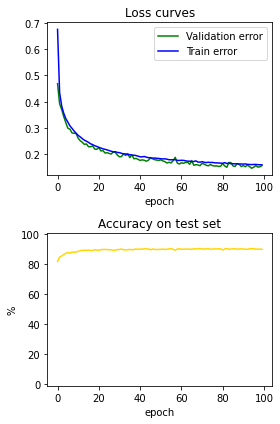

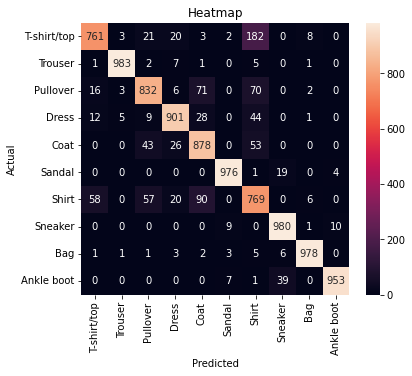

In [13]:
if load:
    # load the model instead of doing the gridsearch:
    best_model = CNNMnistNet(10, [3,6], activation = nn.ReLU(), dropout=0)
    best_model.load_state_dict(torch.load('./models/bestclassificator'))
    best_model.compute_accuracy(heatmap=True, verbose=True)
else:
    # Hyperparameters for the gridsearch:
    grid_lrs = [1e-4,1e-3]
    grid_regs =  [1e-4]
    grid_channels = [[6,12]]
    grid_dropouts = [.1,.01] 
    grid_activations = [nn.ReLU(), nn.Sigmoid()]
    grid_losses = [nn.CrossEntropyLoss()]

    best_train_loss = 1000000
    best_val_loss   = 1000000

    grid_epochs = 10

    i = 0 # Loop variable, tells us at what configuration we currently are

    for grid_lr in grid_lrs:
        for grid_loss in grid_losses:
            for grid_reg in grid_regs:
                for grid_channel in grid_channels:
                    for grid_dropout in grid_dropouts:
                        for grid_activation in grid_activations:
                            # For every possible combination of hyperparameters...
                            grid_model = CNNMnistNet(10, grid_channel, activation = grid_activation, dropout=grid_dropout)
                            grid_val_loss = grid_model.fit(train_dataloader, grid_epochs, 5, grid_loss, 0, grid_lr, 
                                                           reg_term = grid_reg)

                            if grid_val_loss < best_val_loss:
                                best_val_loss = grid_val_loss

                                # Save the best combination of the hyperparameters in a dictionary
                                # so we can inspect the best model later
                                best_config = {
                                  "lr":            grid_lr,
                                  "loss":          grid_loss,
                                  "reg":           grid_reg,
                                  "channels":      grid_channel,
                                  "dropout":       grid_dropout,
                                  "activation":    grid_activation}

                                if True: # Set to False, too much useless information displayed
                                    print('---------------------')
                                    print('Configuration', i)
                                    print(' Validation loss: ', grid_val_loss)
                                    print(' Lr =           ', grid_lr)
                                    print(' Loss =         ', grid_loss)
                                    print(' Reg =          ', grid_reg)
                                    print(' Channels =     ', grid_channel)
                                    print(' dropout =      ', grid_dropout)
                                    print(' activation =   ', grid_activation)
                                    print('')

                            i = i + 1
                            print('Iteration:',i)
                            
    print('Best model found: ')
    print(best_config)                            
    best_model = CNNMnistNet(10, best_config['channels'], activation = best_config['activation'], dropout=best_config['dropout'])
    best_model.fit(train_dataloader, 100, 5, best_config['loss'], 0, best_config['lr'], reg_term = best_config['reg'], test=True, figname='bestmodel_losses')

    best_model.compute_accuracy(heatmap='best_classificator_grid', verbose=True)
    best_model.save()
    

### Filter visualization

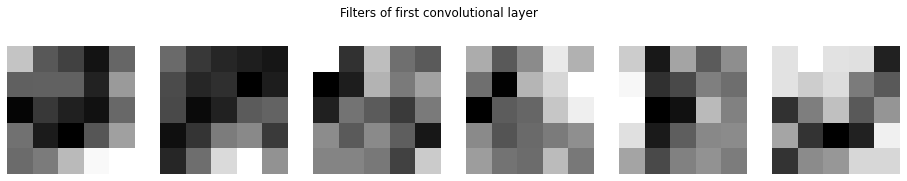

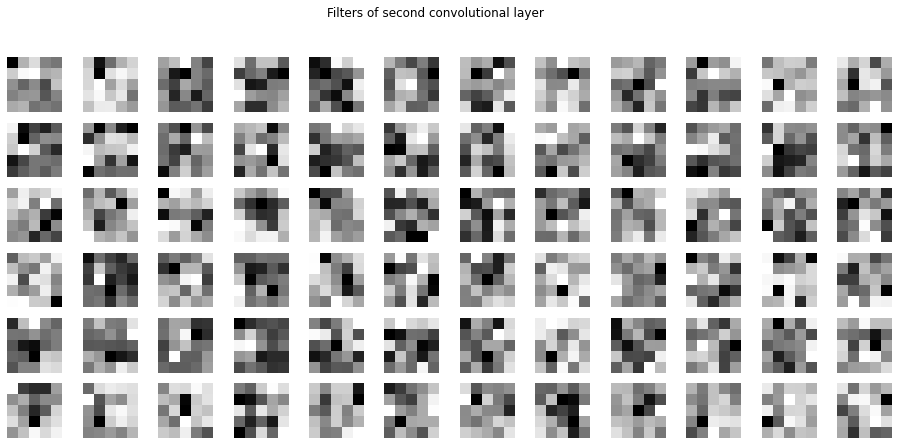

In [14]:
best_model.plot_filters(figname='trained')

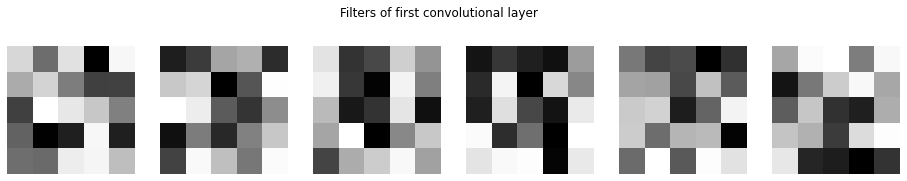

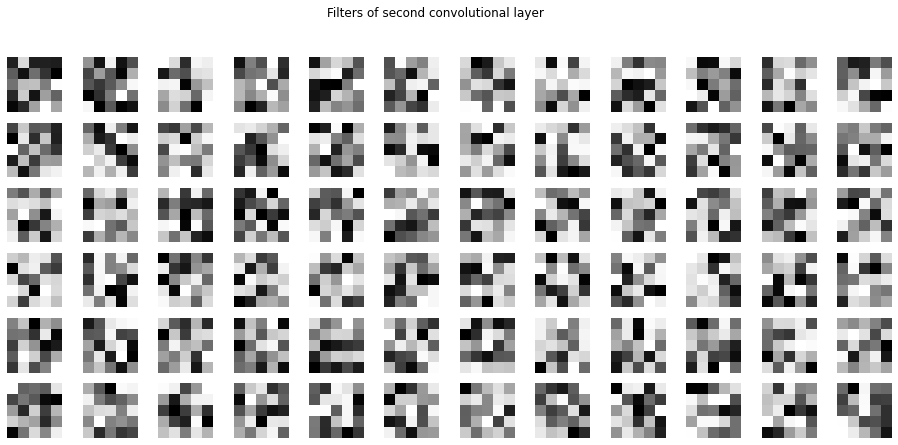

In [15]:
untrained_net = CNNMnistNet(10, [6,12], activation = nn.ReLU(), dropout=0)
untrained_net.plot_filters(figname='untrained')

### Activation layer

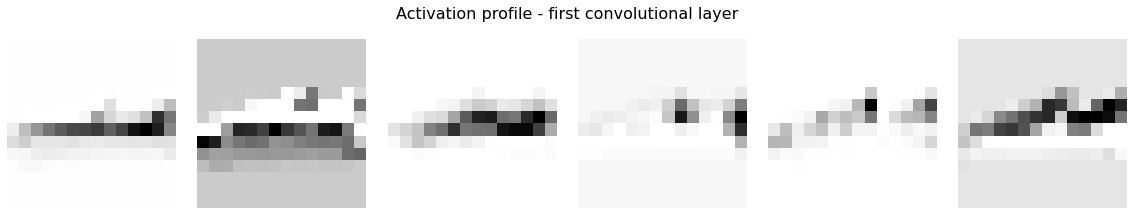

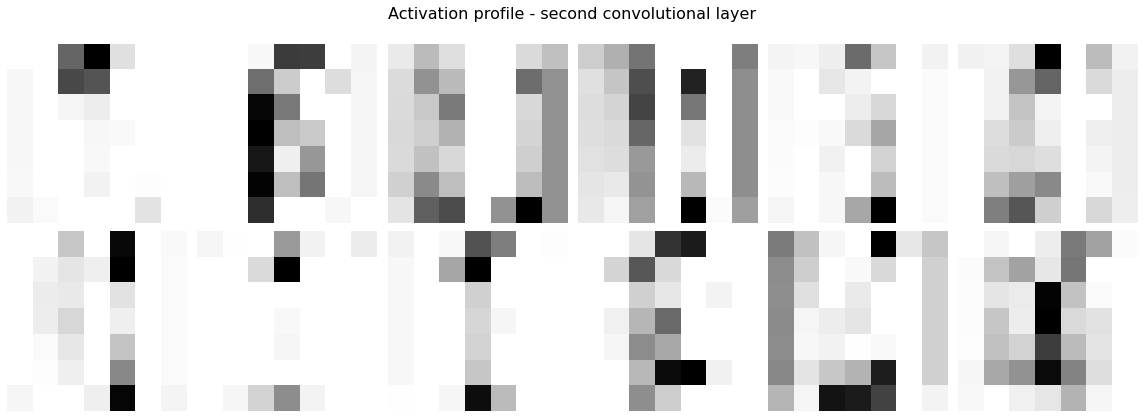

In [16]:
best_model.plot_activations(figname='trained')


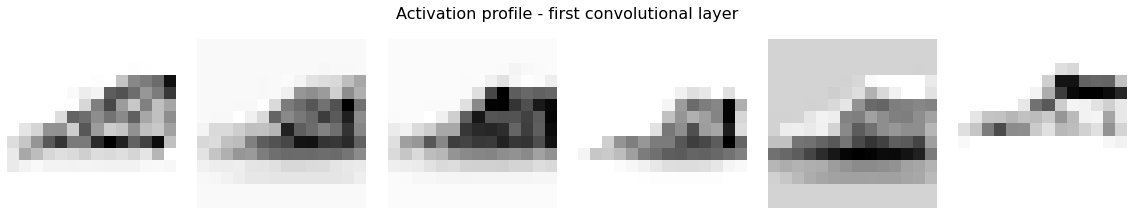

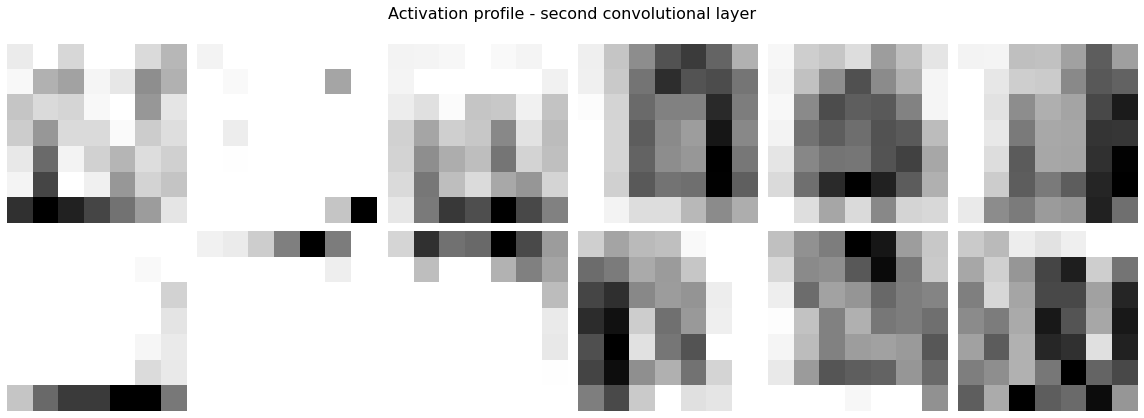

In [17]:
untrained_net.to(device).plot_activations(figname='untrained')

## Appendix

### Data Augmentation

In [18]:
augmentation = transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.RandomVerticalFlip(p=0.5),
                     transforms.RandomCrop(28,padding=2)])


In [19]:
aug_train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=False,
                                                     transform = augmentation )

aug_train_dataloader = DataLoader(aug_train_dataset, batch_size = 100, shuffle=True, num_workers=0)


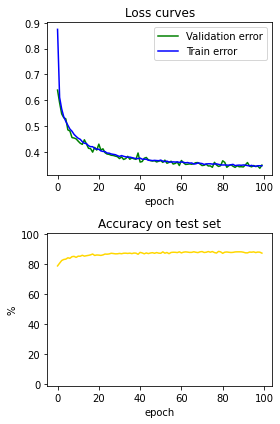

Accuracy: 87.55 %


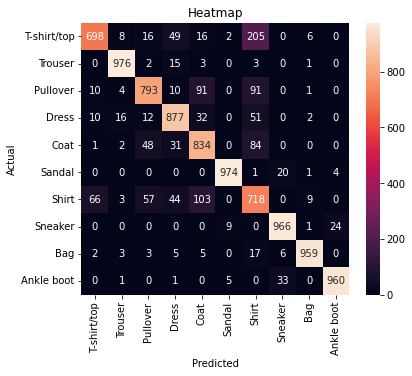

In [20]:
if not load:
    aug_model = CNNMnistNet(10, best_config['channels'], activation = best_config['activation'], dropout=best_config['dropout'])
    aug_model.fit(aug_train_dataloader, 100, 5, best_config['loss'], 0, best_config['lr'], reg_term = best_config['reg'], test=True)

    aug_model.compute_accuracy(heatmap=True, verbose=True)


### Transfer learning, intentional overkill

In [21]:
class fashion_resnet(nn.Module):
    '''
    Modified pre-trained Resnet50
    '''
    def __init__(self):
        super(fashion_resnet, self).__init__()

        # Load a pretrained resnet model
        self.model = torchvision.models.resnet50(pretrained=True)

        # We are dealing with grayscale images, hence input parameters of Conv2d must be 1
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
        # Change the output layer to output 10 classes instead of 1000 classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                                      nn.ReLU(True),
                                      nn.Dropout(.02),
                                      nn.Linear(256,256),
                                      nn.ReLU(True),
                                      nn.Linear(256,10))
                                      

    def forward(self, x):
        return self.model(x)
    
    def compute_accuracy(self, heatmap = False, verbose = False, examples=False):
        '''
        Compute accuracy of the model (%) from the testset
        heatmap  = True shows heatmap
        verbose  = True prints accuracy
        examples = True display some examples
        '''
        self.to('cpu')
        self.eval()
        # Input and true label
        x_test,y_test = next(iter(test_dataloader))
        # Prediction
        y_pred = self(x_test).argmax(dim=1)
        
        description = ['T-shirt/top','Trouser','Pullover',
                   'Dress','Coat','Sandal','Shirt',
                   'Sneaker','Bag','Ankle boot']
        
        misclas = 0
        for i in range(len(y_pred) ):
            if y_pred[i] != y_test[i]:
                misclas = misclas + 1
        
        accuracy = 100*(len(y_pred) - misclas)/len(y_pred)
        
        if verbose:
            print('Accuracy:', accuracy, '%' )
            
        if heatmap:
            conf_mat = confusion_matrix(y_test, y_pred.cpu())
            fig, ax = plt.subplots(figsize=(10,8))
            plt.title('Heatmap')
            sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=description, yticklabels=description)
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            
            if type(heatmap) is str:
                plt.savefig('./imgs/classification/'+heatmap+'.svg', format='svg')
            else:
                plt.show()
            
        if examples:
            indices = np.random.choice(np.arange(len(test_dataloader.dataset) ), size=5, replace=False)
            
            for index in indices:
                image = np.array(x_test[index][0])
                label = y_test[index]

                fig = plt.figure(figsize=(3,3))
                plt.imshow(image, cmap='Greys')
    
                print(f"\n\nTrue Label: {description[label]}")
                print(f"Prediction: {description[y_pred[index]]}")
    
                plt.axis("off")
                plt.show()
            
        return accuracy
    
    def train_epoch(self, device, progress, loss_fn, optimizer, total_loss):
        '''
        Train the network for a single step
        '''
        self.train()
        
        # For each batch
        for i, data in progress:
            X, y = data[0].to(device), data[1].to(device) # X input, y label
            
            # training step for single batch
            self.zero_grad()
            pred = self(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

            # getting training quality data
            current_loss = loss.item() # Extract loss value as float
            total_loss += current_loss

            # updating progress bar
            progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
        # releasing unceseccary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        return optimizer, total_loss
    
    def val_epoch(self, device, progress, loss_fn, optimizer, total_loss):
        # set model to evaluating (testing)
        self.eval()
        misclas = 0
        val_losses = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                X, y = data[0].to(device), data[1].to(device)

                pred = self(X) # this get's the prediction from the network

                val_losses += loss_fn(pred, y)
            
        return total_loss
                
    
    def trainingloop(self, epochs, loss_fn = nn.CrossEntropyLoss(), lr0=1e-3):
        # Eventually move model to GPU
        self.to(device)
        
        # Define optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr0)
        
        batches = len(train_dataloader)
        val_batches = len(test_dataloader)
        
        losses = []
        for epoch in range(epochs):
            total_loss = 0
            progress = tqdm(enumerate(train_dataloader), desc="Loss: ", total=batches)
            
            # ----------------- TRAINING  --------------------
            optimizer, total_loss = self.train_epoch(device, progress, loss_fn, optimizer, total_loss)
            
            # ----------------- VALIDATION  ----------------- 
            total_loss = self.val_epoch(device, progress, loss_fn, optimizer, total_loss)
            
            losses.append(total_loss/batches) # for plotting learning curve
            
        return losses
            
    def save(self, file=False):
        '''
        Just save the model in ./models folder.
        if file = False it overwrites ./models/resnet.pth. else it saves it on the name specified
        '''
        if file:
            torch.save(self.state_dict(), './models/'+str(file))
        else:
            torch.save(self.state_dict(), './models/resnet.pth')

In [22]:
tmodel = fashion_resnet()


In [23]:
if not load:
    tmodel.trainingloop(100)
    torch.save(tmodel.state_dict(), './models/resnet.pth')
else:
    tmodel.load_state_dict(torch.load('./models/resnet.pth'))
    

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

Loss:   0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
tmodel.compute_accuracy(heatmap='resnet_acc', verbose=True)


Using Transfer-Learning on ResNet50 the accuracy rises up to 92%. The main source of error is because the model does not well distinguish between similar classes such as Shirt/T-Shirt and Pullover/Coat, honestly I don't know if I would distinguish them properly...